# Forecast mobility 

Forecast the mobility indices forward

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import date, timedelta, datetime

plt.style.use('seaborn-poster')
value_vars=['retail_and_recreation_percent_change_from_baseline',
                            'grocery_and_pharmacy_percent_change_from_baseline',
                            'parks_percent_change_from_baseline',
                            'transit_stations_percent_change_from_baseline',
                            'workplaces_percent_change_from_baseline',
                            'residential_percent_change_from_baseline']
mov_values = [ val[:-29]+'_7days' for val in value_vars]
states_initials ={
    'Western Australia':'WA',
    'South Australia':'SA',
    'Tasmania':'TAS',
    'Queensland':'QLD',
    'New South Wales':'NSW',
    'Victoria':'VIC',
    'Australian Capital Territory':'ACT',
    'Northern Territory':'NT'
}
def read_in_google(Aus_only=True,local=False,moving=False):
    """
    Read in the Google data set
    """
    if local:
        if type(local)==str:
            df = pd.read_csv(local,parse_dates=['date'])
        elif type(local)==bool:
            local = '../data/Global_Mobility_Report.csv'
            df = pd.read_csv(local,parse_dates=['date'])
    else:
        df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv',parse_dates=['date'])
    
    
    if Aus_only:
        df = df.loc[df.country_region_code=='AU']
        #Change state column to state initials
        df['state'] = df.sub_region_1.map(lambda x: states_initials[x] if not pd.isna(x) else 'AUS' )

    if moving:
        # generate moving average columns in reverse
        df = df.sort_values(by='date')
        mov_values = []
        for val in value_vars:
            mov_values.append(val[:-29]+'_7days')
            #forward looking 7 day average
            df[mov_values[-1]]=df.groupby(['state'])[val].transform(lambda x: x[::-1].rolling(7,1).mean()[::-1]) #minimum number of 1
            
            #minimum of 7 days for std, forward fill the rest
            df[mov_values[-1]+'_std'] = df.groupby(['state'])[val].transform(
                lambda x: x[::-1].rolling(7,7).std()[::-1])
            #fill final values as std doesn't work with single value
            df[mov_values[-1]+'_std'] = df.groupby('state')[mov_values[-1]+'_std'].fillna(method='ffill')
    print("Last Google date is "+ str(df.date.values[-1]) )
    return df

def read_in_posterior(date='2020-07-06'):
    """
    read in samples from posterior from inference
    """
    df = pd.read_hdf("../data/soc_mob_posterior"+date+".h5", key='samples')
    
    return df

In [2]:
df_google = read_in_google(Aus_only=True,moving=True,local=True)
states = ['NSW','QLD','SA','VIC','TAS','WA','ACT','NT','AUS']
plot_states = states.copy()
plot_states.remove('AUS')
df_samples = read_in_posterior()

df_google.tail(20)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Last Google date is 2020-07-03T00:00:00.000000000


,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,...,grocery_and_pharmacy_7days,grocery_and_pharmacy_7days_std,parks_7days,parks_7days_std,transit_stations_7days,transit_stations_7days_std,workplaces_7days,workplaces_7days_std,residential_7days,residential_7days_std
7654,AU,Australia,Australian Capital Territory,NaN,AU-ACT,NaN,2020-07-01,-15.0,3.0,0.0,...,3.666667,2.516611,1.666667,29.455374,-33.666667,5.740416,-18.0,7.114706,10.333333,3.532165
7794,AU,Australia,New South Wales,NaN,AU-NSW,NaN,2020-07-01,-14.0,-2.0,-3.0,...,-0.333333,2.645751,-1.666667,9.172942,-35.666667,6.023762,-17.0,4.386125,9.000000,2.267787
7935,AU,Australia,Northern Territory,NaN,AU-NT,NaN,2020-07-02,10.0,11.0,41.0,...,13.500000,1.772811,44.000000,3.101459,-21.500000,5.398412,-7.0,3.505098,3.500000,1.397276
8495,AU,Australia,Victoria,NaN,AU-VIC,NaN,2020-07-02,-27.0,-6.0,-23.0,...,-5.500000,2.340126,-36.500000,17.506461,-60.500000,7.204496,-35.0,10.843036,16.000000,3.265986
8635,AU,Australia,Western Australia,NaN,AU-WA,NaN,2020-07-02,-3.0,-1.0,-8.0,...,1.000000,3.408672,-9.500000,13.562905,-29.500000,5.740416,-4.0,2.563480,4.500000,0.690066
8075,AU,Australia,Queensland,NaN,AU-QLD,NaN,2020-07-02,-9.0,2.0,21.0,...,2.000000,2.115701,19.500000,15.162611,-37.000000,4.956958,-22.5,4.879500,6.500000,1.511858
8355,AU,Australia,Tasmania,NaN,AU-TAS,NaN,2020-07-02,-22.0,-12.0,-52.0,...,-11.000000,1.603567,-50.500000,5.798193,-42.000000,4.298394,-5.0,5.477226,7.500000,0.755929
7655,AU,Australia,Australian Capital Territory,NaN,AU-ACT,NaN,2020-07-02,-13.0,4.0,-1.0,...,4.000000,2.516611,2.500000,29.455374,-32.000000,5.740416,-17.5,7.114706,10.000000,3.532165
7515,AU,Australia,NaN,NaN,NaN,NaN,2020-07-02,-14.0,-1.0,-1.0,...,0.500000,2.070197,-7.500000,5.219013,-39.500000,4.197505,-20.5,4.750940,9.500000,1.812654
8215,AU,Australia,South Australia,NaN,AU-SA,NaN,2020-07-02,-7.0,3.0,-26.0,...,3.500000,3.366502,-30.500000,16.080156,-27.000000,3.823486,-8.0,2.751623,6.500000,1.112697


In [3]:
six_weeks = pd.to_datetime(df_google.date.values[-1]) + timedelta(
    days=pd.to_datetime(
        datetime.today()).dayofyear -
    pd.to_datetime(df_google.date.values[-1]).dayofyear + 42)

days_from_March = six_weeks.dayofyear -pd.to_datetime('2020-03-01').dayofyear

days_from_March

171

Forecast ends at 197 days after 1st March
Final date is 2020-09-14 00:00:00


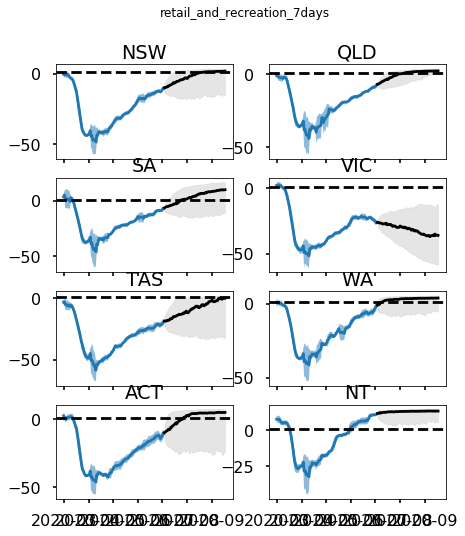

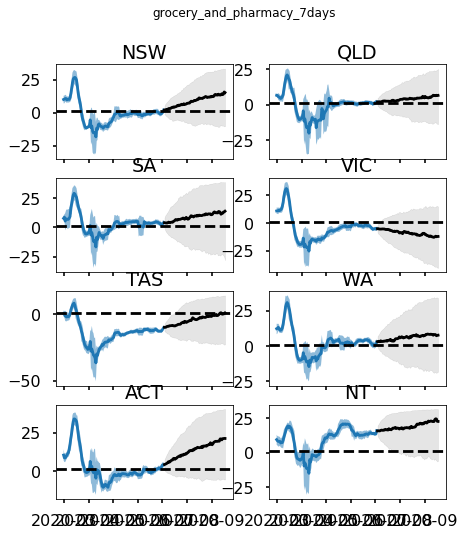

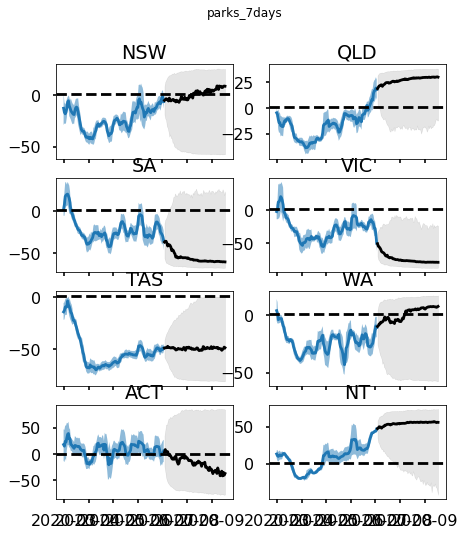

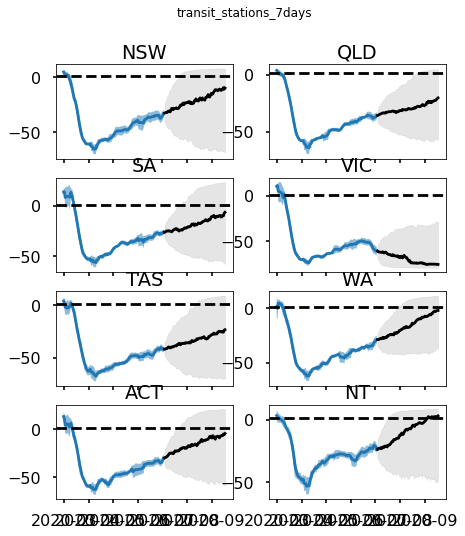

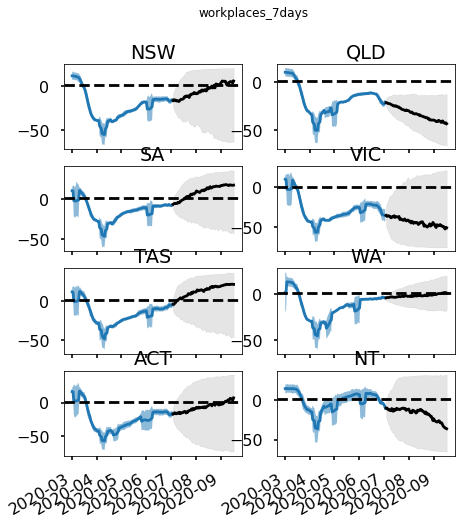

In [80]:
#forecast time parameters
n_training =28
today = '2020-07-06'
n_forecast = 70 + (pd.to_datetime(datetime.today()) - df_google.date.values[-1]).days

#cap = 0 #10?
training_start_date = datetime(2020,3,1,0,0)
print("Forecast ends at {} days after 1st March".format(
    pd.to_datetime(today).dayofyear + 70 - pd.to_datetime(training_start_date).dayofyear)
     )
print("Final date is {}".format(pd.to_datetime(today) + timedelta(days=70)))
df_google = df_google.loc[df_google.date>= training_start_date]
outdata = {'date': [],
           'type': [],
           'state': [],
            'mean': [],
            'std' : [],
          }
predictors = mov_values.copy()
predictors.remove('residential_7days')

mob_samples = 1000
axes = []

for var in predictors:
    
    fig, ax_states = plt.subplots(figsize=(7,8),nrows=4, ncols=2, sharex=True)
    axes.append(ax_states)
    fig.suptitle(var)
    
state_Rmed = {}
state_sims = {}
for i,state in enumerate(states):
    

    
    rownum = int(i/2.)
    colnum = np.mod(i,2)

    rows = df_google.loc[df_google.state==state].shape[0]
    #Rmed currently a list, needs to be a matrix
    Rmed_array = np.zeros(shape=(rows,len(predictors), mob_samples))
    for j, var in enumerate(predictors):
        for n in range(mob_samples):
            Rmed_array[:,j,n] = df_google[df_google['state'] == state][var].values.T + np.random.normal(loc=0,
                                                                              scale = df_google[df_google['state'] == state][var+'_std'],
                                                                             )
    dates = df_google[df_google['state'] == state]['date']
        
        #cap min and max at historical or (-50,0)
    minRmed_array = np.minimum(-50,np.amin(Rmed_array, axis = 0)) #1 by predictors by mob_samples size
    maxRmed_array = np.maximum(0,np.amax(Rmed_array, axis=0))
    sims  =  np.zeros(shape=(n_forecast,len(predictors),mob_samples)) # days by predictors by samples
    for n in range(mob_samples):
        Rmed = Rmed_array[:,:,n]
        minRmed = minRmed_array[:,n]
        maxRmed = maxRmed_array[:,n]
            
        R_diffs = np.diff(Rmed[-n_training:,:], axis=0)


        mu = np.mean(R_diffs, axis=0)
        std = np.cov(R_diffs, rowvar=False) #columns are vars, rows are obs
        sims[:,:,n] = np.minimum(maxRmed,Rmed[-1,:] + np.cumsum(np.random.multivariate_normal(mu,
                                                                  std,
                                                                  size=(n_forecast)),
                                                 axis=0))#rows are sim, dates are columns
        sims[:,:,n] = np.maximum(minRmed, sims[:,:,n])
            #dates of forecast to enter
            
    dd = [dates.tolist()[-1] + timedelta(days=x) for x in range(1,n_forecast+1)]

        #     print(state)

    sims_med = np.median(sims,axis=2) #N by predictors
    sims_q25 = np.percentile(sims,25,axis=2)
    sims_q75 = np.percentile(sims,75,axis=2)

    for j, var in enumerate(predictors):
        #Record data
        axs = axes[j]
        outdata['date'].extend([d.strftime('%Y-%m-%d') for d in dd])
        outdata['type'].extend([var]*len(dd))
        outdata['state'].extend([state]*len(dd))
        outdata['mean'].extend(np.mean(sims[:,j,:],axis=1))
        outdata['std'].extend(np.std(sims[:,j,:],axis=1))
        if state in plot_states:
            axs[rownum,colnum].plot(dates,df_google[df_google['state'] == state][var].values)
            axs[rownum,colnum].fill_between(dates,
                                            np.percentile(Rmed_array[:,j,:], 25, axis =1),
                                            np.percentile(Rmed_array[:,j,:], 75, axis =1),
                                           alpha=0.5)
            
            axs[rownum,colnum].plot(dd,sims_med[:,j],'k')
            axs[rownum,colnum].fill_between(dd, sims_q25[:,j], sims_q75[:,j], color='k',alpha = 0.1)
            axs[rownum,colnum].set_title(state)
            axs[rownum,colnum].axhline(1,ls = '--', c = 'k')


    state_Rmed[state] = Rmed_array
    state_sims[state] = sims


    fig.autofmt_xdate()
    
#plt.savefig('../figs/Reff_forecast_rw_training' + str(n_training) + '.pdf')

In [81]:
df_out = pd.DataFrame.from_dict(outdata)
df_forecast = pd.pivot_table(df_out, columns=['type'],index=['date','state'],values=['mean'])
df_std = pd.pivot_table(df_out, columns=['type'],index=['date','state'],values=['std'])


#align with google order in columns
df_forecast = df_forecast.reindex([('mean',val) for val in predictors],axis=1)
df_std = df_std.reindex([('std',val) for val in predictors],axis=1) 
df_forecast.columns = predictors #remove the tuple name of columns
df_std.columns = predictors

df_forecast = df_forecast.reset_index() 
df_std = df_std.reset_index()
df_forecast.date = pd.to_datetime(df_forecast.date)
df_std.date = pd.to_datetime(df_std.date)

In [82]:
display(df_std.tail()) #forecast up to 
df_forecast.tail()

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days
679,2020-09-17,QLD,9.327895,25.149278,37.314571,31.254162,32.569608
680,2020-09-17,SA,24.916909,37.715220,49.554509,39.047570,46.014315
681,2020-09-17,TAS,26.132621,24.833111,39.945468,37.293859,46.794002
682,2020-09-17,VIC,26.934514,32.978995,57.604443,36.810339,50.024816
683,2020-09-17,WA,17.254884,30.745357,38.594922,30.513030,24.644624


,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days
679,2020-09-17,QLD,-0.286428,3.380041,12.398091,-27.393409,-37.997804
680,2020-09-17,SA,0.035868,5.392971,-32.476682,-13.137479,0.001946
681,2020-09-17,TAS,-16.186640,-6.031168,-41.527576,-27.795040,0.787433
682,2020-09-17,VIC,-34.791127,-10.938778,-50.526160,-52.772425,-31.328663
683,2020-09-17,WA,-3.586660,4.986407,-14.759133,-13.769397,-1.484108


In [83]:
df_R = df_google[['date','state']+mov_values + [val+'_std' for val in mov_values]] 
df_R = pd.concat([df_R,df_forecast],ignore_index=True,sort=False)
df_R['policy'] = (df_R.date>='2020-03-16').astype('int8')

df_R

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days,residential_7days,retail_and_recreation_7days_std,grocery_and_pharmacy_7days_std,parks_7days_std,transit_stations_7days_std,workplaces_7days_std,residential_7days_std,policy
0,2020-03-01,NT,7.428571,9.428571,13.285714,3.285714,14.571429,-0.714286,3.598942,5.563486,7.653197,4.855042,8.243323,1.253566,0
1,2020-03-01,QLD,-0.714286,6.571429,-4.571429,3.571429,10.285714,-1.142857,2.288689,1.511858,5.996030,2.819997,6.848705,1.214986,0
2,2020-03-01,TAS,-3.000000,0.571429,-14.285714,4.142857,11.857143,-0.285714,2.768875,3.359422,12.147898,4.561746,9.299258,1.704336,0
3,2020-03-01,SA,3.571429,7.857143,2.285714,13.714286,10.571429,-1.428571,3.309438,3.532165,11.686378,4.750940,7.524563,0.975900,0
4,2020-03-01,VIC,2.142857,10.857143,-2.285714,10.571429,10.285714,-1.428571,3.287784,4.220133,15.173599,2.439750,7.994045,1.133893,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,2020-09-17,QLD,-0.286428,3.380041,12.398091,-27.393409,-37.997804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1805,2020-09-17,SA,0.035868,5.392971,-32.476682,-13.137479,0.001946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1806,2020-09-17,TAS,-16.186640,-6.031168,-41.527576,-27.795040,0.787433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1807,2020-09-17,VIC,-34.791127,-10.938778,-50.526160,-52.772425,-31.328663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [84]:
#generate posterior estimates of each state
from scipy.special import expit
df_R = df_R.sort_values('date')
n_samples = 100
samples = df_samples.sample(n_samples) #test on sample of 2
forecast_type = ['R_L','R_L0']
state_Rs = {
    'state':[],
    'date':[],
    'type':[],
    'median':[],
    'lower':[],
    'upper':[],
    'bottom':[],
    'top':[],
    'mean':[],
    'std':[],
}
ban = '2020-03-16'
new_pol = '2020-06-01' #VIC and NSW allow gatherings of up to 20 people, other jurisdictions allow for 
typ_state_R={}
mob_forecast_date = df_forecast.date.min()
mob_samples = 1000
print("forecast mobility from "+str(mob_forecast_date))
for typ in forecast_type:
    state_R={}
    for state in states:
    #sort df_R by date so that rows are dates

        #rows are dates, columns are predictors
        df_state = df_R.loc[df_R.state==state]
        dd = df_state.date
        post_values = samples[predictors].values.T
        
        for n in range(mob_samples):
            #add gaussian noise to predictors before forecast
            df_state.loc[df_state.date<mob_forecast_date,predictors] = state_Rmed[state][:,:,n]/100#df_state.loc[
                #df_state.date<mob_forecast_date,predictors]/100 + np.random.normal(
                #loc= 0, scale = df_state.loc[
                #    (df_state.date<mob_forecast_date),
                #    [val+'_std' for val in predictors]].values/100)

            
            #add gaussian noise to predictors after forecast
            df_state.loc[df_state.date>=mob_forecast_date,predictors] = state_sims[state][:,:,n]/100
            #df_state.loc[
             #   df_state.date>=mob_forecast_date,predictors]/100 + np.random.normal(
             #   loc= 0, scale = df_std.loc[(df_std.state==state,predictors)].values/100)

            
            #dd = df_state.date

            df1 =df_state.loc[df_state.date<=ban]
            X1 = df1[predictors] #N by K
            
            
            #take right size of md to be N by N
            md = np.tile(samples['md'].values, (df_state.shape[0],mob_samples))
            sim_R = np.tile(samples.R_L.values, (df_state.shape[0],mob_samples))

            #set initial pre ban values of md to 1
            md[:X1.shape[0],:] = 1


            if n==0:
                #initialise arrays (loggodds)
                logodds = X1 @ post_values # N by K times (Nsamples by K )^T = Ndate by Nsamples
                
                if typ =='R_L':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]
                    X3 = df3[predictors]

                    #halve effect of md
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1- 0.5 *( 1 - md[(X1.shape[0]+df2.shape[0]):,:])

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                    logodds = np.append(logodds,X3 @ post_values,axis=0)

                elif typ=='R_L0':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]
                    X3 = np.zeros_like(df3[predictors])

                    #social mobility all at baseline implies R_l = R_L0

                    #md has no effect after June 1st
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                    logodds = np.append(logodds,X3 @ post_values,axis=0)


                else:
                    #forecast as before, no changes to md
                    df2 = df_state.loc[df_state.date>ban]
                    X2 = df2[predictors]

                    logodds = np.append(logodds,X2 @ post_values,axis=0)
                                    #df_state.loc[df_state.date>'2020-03-15',predictors].values/100 @ samples[predictors].values.T, axis = 0)

            else:
                #concatenate to pre-existing logodds martrix
                logodds1 = X1 @ post_values
                
                if typ =='R_L':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]
                    X3 = df3[predictors]

                    #halve effect of md
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1- 0.5 *( 1 - md[(X1.shape[0]+df2.shape[0]):,:])

                    logodds2 = X2 @ post_values
                    logodds3 = X3 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                    logodds_sample = np.append(logodds_sample, logodds3, axis=0)

                elif typ=='R_L0':
                    df2 = df_state.loc[(df_state.date>ban) & (df_state.date<new_pol)]
                    df3 = df_state.loc[df_state.date>=new_pol]
                    X2 = df2[predictors]
                    X3 = np.zeros_like(df3[predictors])

                    #social mobility all at baseline implies R_l = R_L0

                    #md has no effect after June 1st
                    
                    md[(X1.shape[0]+df2.shape[0]):,:] = 1
                    
                    logodds2 = X2 @ post_values
                    logodds3 = X3 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                    logodds_sample = np.append(logodds_sample, logodds3, axis=0)


                else:
                    #forecast as before, no changes to md
                    df2 = df_state.loc[df_state.date>ban]
                    X2 = df2[predictors]

                    logodds2 = X2 @ post_values
                    
                    logodds_sample = np.append(logodds1, logodds2, axis=0)
                
                ##concatenate to previous
                logodds = np.concatenate((logodds, logodds_sample ), axis =1)

        R_L = 2* md *sim_R * expit( logodds ) 

        R_L_lower = np.percentile(R_L,25,axis=1)
        R_L_upper = np.percentile(R_L,75,axis=1)

        R_L_bottom = np.percentile(R_L,5,axis=1)
        R_L_top = np.percentile(R_L,95,axis=1)


        R_L_med = np.median(R_L,axis=1)

        #R_L
        state_Rs['state'].extend([state]*df_state.shape[0])
        state_Rs['type'].extend([typ]*df_state.shape[0])
        state_Rs['date'].extend(dd.values) #repeat n_samples times?
        state_Rs['lower'].extend(R_L_lower)
        state_Rs['median'].extend(R_L_med)
        state_Rs['upper'].extend(R_L_upper)
        state_Rs['top'].extend(R_L_top)
        state_Rs['bottom'].extend(R_L_bottom)
        state_Rs['mean'].extend(np.mean(R_L,axis=1))
        state_Rs['std'].extend(np.std(R_L,axis=1))
        
        state_R[state] = R_L
    typ_state_R[typ] = state_R
    
    
    
for state in states:
    #R_I
    R_I = samples['R_I'].values[:df_state.shape[0]]
    
    
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['R_I']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(np.repeat(np.percentile(R_I,25),df_state.shape[0]))
    state_Rs['median'].extend(np.repeat(np.median(R_I),df_state.shape[0]))
    state_Rs['upper'].extend(np.repeat(np.percentile(R_I,75),df_state.shape[0]))
    state_Rs['top'].extend(np.repeat(np.percentile(R_I,95),df_state.shape[0]))
    state_Rs['bottom'].extend(np.repeat(np.percentile(R_I,5),df_state.shape[0]))
    state_Rs['mean'].extend(np.repeat(np.mean(R_I),df_state.shape[0]))
    state_Rs['std'].extend(np.repeat(np.std(R_I),df_state.shape[0]))
    
    
    

forecast mobility from 2020-07-04 00:00:00


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [85]:
df_Rhats = pd.DataFrame().from_dict(state_Rs)
df_Rhats = df_Rhats.set_index(['state','date','type'])

d = pd.DataFrame()
for state in states:
    for i,typ in enumerate(forecast_type):
        if i==0:
            t = pd.DataFrame.from_dict(typ_state_R[typ][state])
            t['date'] = dd.values
            t['state'] = state
            t['type'] = typ
        else:
            temp = pd.DataFrame.from_dict(typ_state_R[typ][state])
            temp['date'] = dd.values
            temp['state'] = state
            temp['type'] = typ
            t = t.append(temp)   
    #R_I
    i = pd.DataFrame(np.tile(samples['R_I'].values,(len(dd.values),100)))
    i['date'] = dd.values
    i['type'] = 'R_I'
    i['state'] = state

    t = t.append(i)
        
    d = d.append(t)
        
        #df_Rhats = df_Rhats.loc[(df_Rhats.state==state)&(df_Rhats.type=='R_L')].join( t)

d = d.set_index(['state','date','type'])
df_Rhats = df_Rhats.join(d)
df_Rhats = df_Rhats.reset_index()
df_Rhats.state = df_Rhats.state.astype(str)
df_Rhats.type = df_Rhats.type.astype(str)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


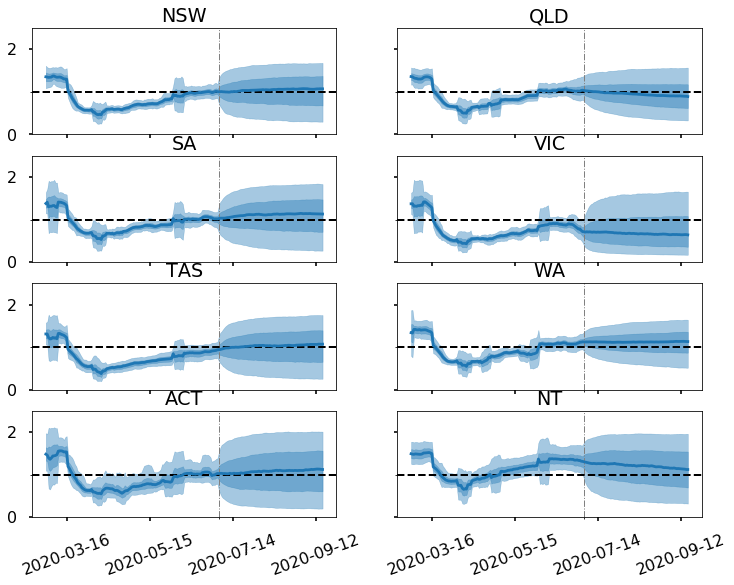

In [86]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='R_L')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,2,3],minor=False)
    ax[row,col].set_yticklabels([0,2,3],minor=False)
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,2.5))
    
    ax[row,col].set_xticks([plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
#fig.autofmt_xdate()
plt.savefig("../figs/soc_mob_R_L_hats.pdf")    
plt.show()

In [92]:
df_Rhats = df_Rhats[['state','date','type','median','bottom','lower','upper','top']+[i+10*i for i in range(100)]
                    #+[3*i+mob_samples*i for i in range(mob_samples)]
                   ]
df_Rhats.columns = ['state','date','type','median','bottom','lower','upper','top'] + [i for i in range(100)]
df_Rhats

,state,date,type,median,bottom,lower,upper,top,0,1,...,90,91,92,93,94,95,96,97,98,99
0,NSW,2020-03-01,R_L,1.354334,1.085698,1.253108,1.457705,1.615421,1.152149,1.335846,...,1.266263,1.378484,1.551392,1.349384,1.713799,1.515277,1.503625,1.452312,1.532087,1.593131
1,NSW,2020-03-02,R_L,1.347181,1.100418,1.251701,1.441388,1.578103,1.126808,1.299377,...,1.072096,1.316720,1.393024,1.230746,1.559615,1.393289,1.375837,1.287575,1.423075,1.407798
2,NSW,2020-03-03,R_L,1.341412,1.105233,1.250147,1.431509,1.565258,1.368345,1.497191,...,1.225045,1.396952,1.280283,1.166481,1.622812,1.290892,1.368630,1.140536,1.449198,1.262932
3,NSW,2020-03-04,R_L,1.345017,1.114704,1.255063,1.434518,1.563067,1.456959,1.585019,...,1.305648,1.344448,1.256900,1.156158,1.495014,1.246502,1.248626,1.114977,1.379367,1.245759
4,NSW,2020-03-05,R_L,1.348820,1.129927,1.259530,1.438738,1.573093,1.408378,1.594531,...,0.977513,1.330912,1.264276,1.141103,1.535148,1.262768,1.315554,1.143656,1.389031,1.293232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,AUS,2020-09-13,R_I,0.101474,0.078927,0.090416,0.109727,0.123875,0.122278,0.087356,...,0.112025,0.120024,0.108961,0.114137,0.085483,0.124376,0.123849,0.103482,0.091408,0.114321
5423,AUS,2020-09-14,R_I,0.101474,0.078927,0.090416,0.109727,0.123875,0.122278,0.087356,...,0.112025,0.120024,0.108961,0.114137,0.085483,0.124376,0.123849,0.103482,0.091408,0.114321
5424,AUS,2020-09-15,R_I,0.101474,0.078927,0.090416,0.109727,0.123875,0.122278,0.087356,...,0.112025,0.120024,0.108961,0.114137,0.085483,0.124376,0.123849,0.103482,0.091408,0.114321
5425,AUS,2020-09-16,R_I,0.101474,0.078927,0.090416,0.109727,0.123875,0.122278,0.087356,...,0.112025,0.120024,0.108961,0.114137,0.085483,0.124376,0.123849,0.103482,0.091408,0.114321


In [93]:
from datetime import datetime
today = datetime.strftime(datetime.today(),format='%Y-%m-%d')

#df_Rhats.to_csv('./soc_mob_R'+today+'.csv')
df_Rhats.to_hdf('../data/soc_mob_R'+today+'.h5',key='Reff')


/anaconda3/lib/python3.6/site-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/anaconda3/lib/python3.6/site-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_items] [items->None]

  f(store)


In [70]:
df_Rhats.dtypes

state             object
date      datetime64[ns]
type              object
median           float64
bottom           float64
               ...      
95               float64
96               float64
97               float64
98               float64
99               float64
Length: 108, dtype: object

In [17]:
df_Rhats.loc[df_Rhats.state=='NT'].head(20)
display(d.loc[('VIC')].head(40))

,,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
date,type,,,,,,,,,,,,,,,,,,,,,
2020-03-01,R_L,2.226117,1.999202,2.298268,1.940207,2.177900,1.998405,2.376381,2.010491,2.084179,1.998354,...,2.168599,2.215366,1.955967,1.882867,2.321299,2.197079,2.039537,2.390135,1.835034,2.040480
2020-03-02,R_L,2.242050,2.044374,2.357916,1.962285,2.206088,2.017725,2.403727,2.031362,2.115776,2.043621,...,2.217376,2.231581,1.971082,1.912794,2.349411,2.200772,2.085071,2.408641,1.858484,2.043990
2020-03-03,R_L,2.295474,2.266727,2.672647,2.024149,2.323215,2.115462,2.423825,2.163233,2.152753,2.315459,...,2.250157,2.211468,2.066164,2.025857,2.298196,2.211501,2.282586,2.361086,2.004274,2.138315
2020-03-04,R_L,2.295242,2.281505,2.689480,2.029468,2.327800,2.125129,2.426096,2.169299,2.159291,2.331759,...,2.260499,2.213124,2.077054,2.038308,2.302062,2.214396,2.300485,2.364470,2.013821,2.140780
2020-03-05,R_L,2.283900,2.304811,2.735715,2.036796,2.337751,2.139327,2.432357,2.178186,2.178815,2.353938,...,2.308699,2.199127,2.075976,2.052321,2.318466,2.206059,2.310236,2.352089,2.026723,2.125506
2020-03-06,R_L,2.284224,2.370676,2.855863,2.068747,2.381513,2.195945,2.467191,2.224541,2.227748,2.427640,...,2.406908,2.206374,2.103836,2.103751,2.369992,2.219591,2.363347,2.363624,2.068268,2.125908
2020-03-07,R_L,2.262543,2.344628,2.801887,2.051325,2.348733,2.177088,2.439439,2.195494,2.208836,2.395744,...,2.378622,2.188601,2.098452,2.089713,2.348176,2.208864,2.346108,2.349902,2.052780,2.111103
2020-03-08,R_L,2.232075,2.295653,2.725267,2.027021,2.305259,2.173837,2.399407,2.171659,2.171069,2.350703,...,2.320054,2.177125,2.109573,2.074415,2.319379,2.220998,2.317875,2.344028,2.031971,2.112832
2020-03-09,R_L,2.176730,2.223413,2.609016,1.986023,2.233041,2.165647,2.328566,2.130397,2.110576,2.283427,...,2.229710,2.145304,2.123833,2.050025,2.265612,2.230709,2.273709,2.320297,2.002000,2.108740


# Interpretation
Exmaine what macro and micro distancing means in regards to baseline and current values.

In [14]:
# Plot logistic function over time

ban = '2020-03-20'
for state in states:
#sort df_R by date so that rows are dates
    df_state = df_R.loc[df_R.state==state]
    
    
    post_values = samples[predictors].values.T
    dd = df_state.date
    
    df1 =df_state.loc[df_state.date<=ban]
    df2 = df_state.loc[df_state.date>ban]
    X1 = df1[predictors]/100 #N by K
    X2 = df2[predictors]/100
    logodds = X1 @ post_values # N by K times (Nsamples by K )^T = N by N
    md = samples['md'].values.copy()
    
    #logodds = df_state.loc[df_state.date<='2020-03-15',predictors].values/100 @ samples[predictors].values.T #row is a date, column is a posterior sample
    md[:logodds.shape[0]] = 1
    
    logodds = np.append(logodds,X2 @ post_values,axis=0)
                        #df_state.loc[df_state.date>'2020-03-15',predictors].values/100 @ samples[predictors].values.T, axis = 0)
    factor = 2* md* expit( logodds ) 
    
    
    factor_lower = np.percentile(factor,25,axis=1)
    factor_upper = np.percentile(factor,75,axis=1)
    
    factor_bottom = np.percentile(factor,5,axis=1)
    factor_top = np.percentile(factor,95,axis=1)

    
    factor_med = np.median(factor,axis=1)
    
    #factor
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['factor']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(factor_lower)
    state_Rs['median'].extend(factor_med)
    state_Rs['upper'].extend(factor_upper)
    state_Rs['top'].extend(factor_top)
    state_Rs['bottom'].extend(factor_bottom)
    state_Rs['mean'].extend(np.mean(factor,axis=1))
    state_Rs['std'].extend(np.std(factor,axis=1))
    
    #now do without microdistnacing
    no_md = 2*expit(logodds)
    factor = no_md
    factor_lower = np.percentile(factor,25,axis=1)
    factor_upper = np.percentile(factor,75,axis=1)
    
    factor_bottom = np.percentile(factor,5,axis=1)
    factor_top = np.percentile(factor,95,axis=1)

    
    factor_med = np.median(factor,axis=1)
    
    #no md
    state_Rs['state'].extend([state]*df_state.shape[0])
    state_Rs['type'].extend(['no_md']*df_state.shape[0])
    state_Rs['date'].extend(dd.values)
    state_Rs['lower'].extend(factor_lower)
    state_Rs['median'].extend(factor_med)
    state_Rs['upper'].extend(factor_upper)
    state_Rs['top'].extend(factor_top)
    state_Rs['bottom'].extend(factor_bottom)
    state_Rs['mean'].extend(np.mean(factor,axis=1))
    state_Rs['std'].extend(np.std(factor,axis=1))

    
df_Rhats = pd.DataFrame().from_dict(state_Rs)

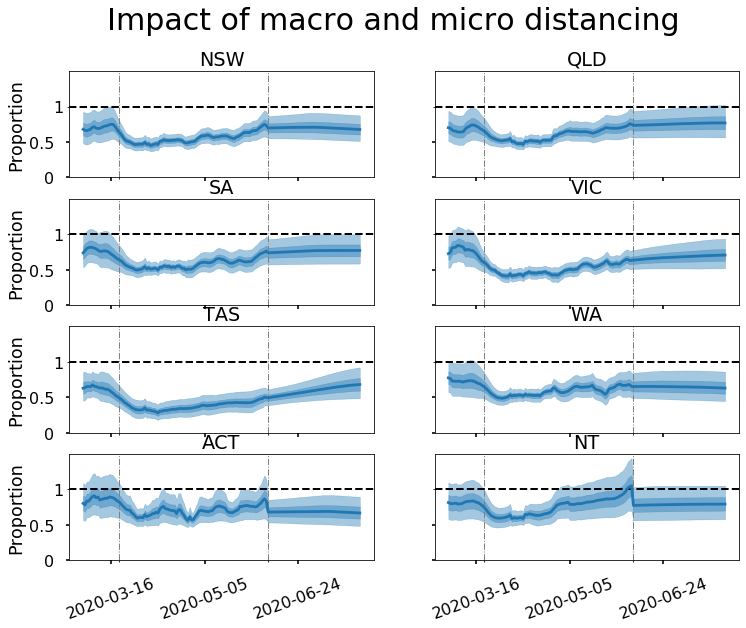

In [15]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='factor')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,0.5],minor=False)
    ax[row,col].set_yticklabels([0,0.5],minor=False)
    ax[row,col].set_yticklabels([1],minor=True)
    
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,1.5))
    
    ax[row,col].set_xticks([ban,plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
    
    if col==0:
        ax[row,col].set_ylabel('Proportion')
    
#fig.autofmt_xdate()
fig.suptitle("Impact of macro and micro distancing", fontsize=30)
plt.savefig("./figs/distance_impact.pdf")    
plt.show()

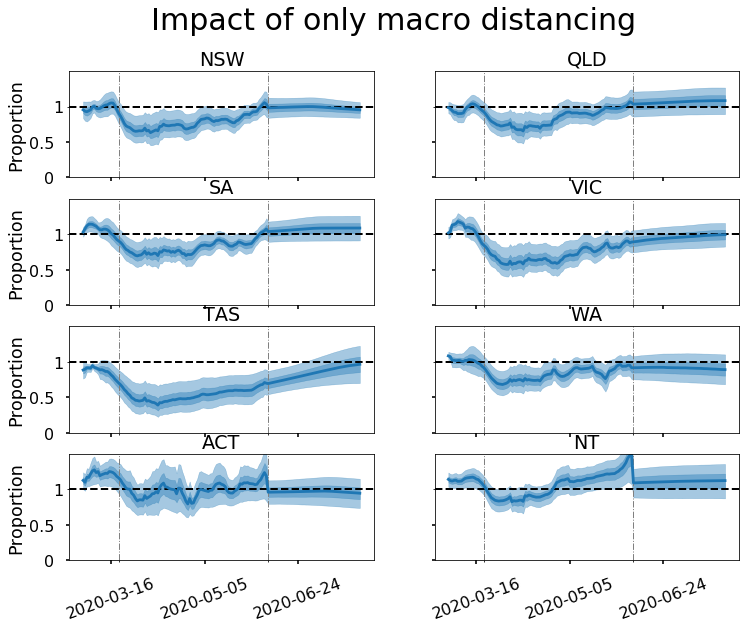

In [16]:
fig, ax = plt.subplots(figsize=(12,9), nrows=4,ncols=2,sharex=True, sharey=True)

plt.locator_params(axis='x',nbins=2)
for i,state in enumerate(plot_states):
    
    row = i//2
    col = i%2
    
    plot_df = df_Rhats.loc[(df_Rhats.state==state)& (df_Rhats.type=='no_md')]
    
    ax[row,col].plot(plot_df.date, plot_df['median'])
    
    ax[row,col].fill_between( plot_df.date, plot_df['lower'],plot_df['upper'],alpha=0.4,color='C0')
    ax[row,col].fill_between( plot_df.date, plot_df['bottom'],plot_df['top'],alpha=0.4,color='C0')
    
    ax[row,col].tick_params('x',rotation=20)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].set_title(state)
    ax[row,col].set_yticks([1],minor=True,)
    ax[row,col].set_yticks([0,0.5],minor=False)
    ax[row,col].set_yticklabels([0,0.5],minor=False)
    ax[row,col].set_yticklabels([1],minor=True)
    ax[row,col].yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    ax[row,col].set_ylim((0,1.5))
    
    ax[row,col].set_xticks([ban,plot_df.date.values[-n_forecast]],minor=True,)
    ax[row,col].xaxis.grid(which='minor', linestyle='-.',color='grey', linewidth=1)
    if col==0:
        ax[row,col].set_ylabel('Proportion')
#fig.autofmt_xdate()
fig.suptitle("Impact of only macro distancing", fontsize=30)
plt.savefig("./figs/macro.pdf")    
plt.show()

## Effect of distancing on $R_L$

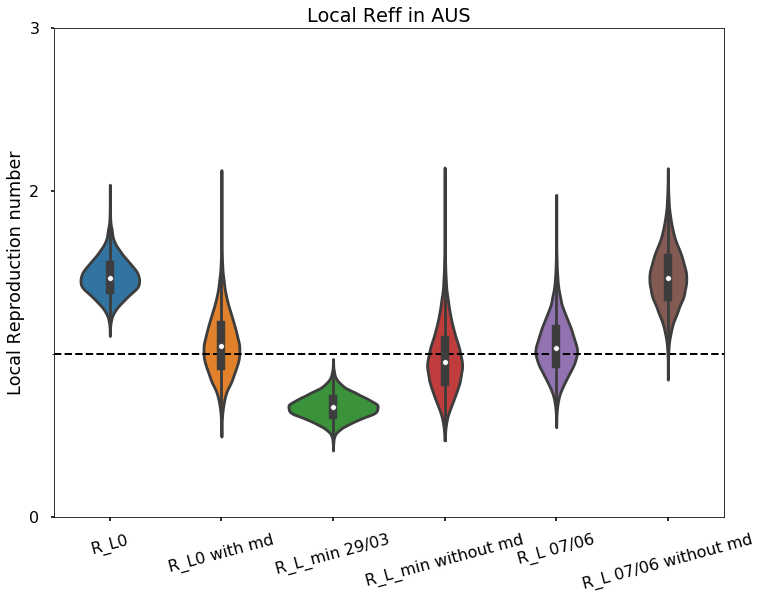

In [17]:
import seaborn as sns
df_samples['R_L0'] = samples.R_L
df_samples['R_L0 with md'] = samples.R_L * samples.md

##take lowest point in NSW data
min_row = df_Rhats.loc[(df_Rhats.state=='AUS') & 
                       (df_Rhats.type=='factor'),'mean'].values.argmin()

min_date= df_Rhats.iloc[min_row].date #29th March
X = df_R.loc[(df_R.date==min_date)&(df_R.state=='AUS'),predictors].values/100 #predictors
    
post_values = samples[predictors].values.T #K by 1000

min_RL = 2*samples.R_L.values*samples.md.values*expit(X @ post_values) # 1 by K times K 1000
min_RL_nomd = 2*samples.R_L.values*expit(X @ post_values) # 1 by K times K 1000
df_samples['R_L_min 29/03'] = min_RL.flatten()
df_samples['R_L_min without md'] = min_RL_nomd.flatten()

#Take last Google index, 21st May
last_date = df_google.date.values[-1]
last_date_str = pd.to_datetime(str(last_date)).strftime('%d/%m')
X = df_R.loc[(df_R.date==last_date)&(df_R.state=='AUS'),predictors].values/100 #predictors
    

post_values = samples[predictors].values.T #K by 1000

last_RL = 2*samples.R_L.values*samples.md.values*expit(X @ post_values) # 1 by K times K 1000
last_RL_nomd = 2*samples.R_L.values*expit(X @ post_values) # 1 by K times K 1000
df_samples['R_L '+last_date_str] = last_RL.flatten()
df_samples['R_L '+last_date_str+' without md'] = last_RL_nomd.flatten()

plot_df = pd.melt(df_samples[
    ['R_L0','R_L0 with md','R_L_min 29/03', 
     'R_L_min without md', 'R_L '+last_date_str,'R_L '+last_date_str+' without md']
])


fig,ax = plt.subplots(figsize=(12,9))
sns.violinplot(
        x='variable',
        y='value',
        data = plot_df,
        ax=ax,
    cut=0,
)
ax.set_title("Local Reff in AUS")
ax.set_yticks([1],minor=True,)
ax.set_yticks([0,2,3],minor=False)
ax.set_ylabel('Local Reproduction number')
ax.set_xlabel('')
ax.tick_params('x', rotation=15)
ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.savefig('./figs/Local.pdf')
plt.show()

NSW
retail_and_recreation_7days    0.785147
grocery_and_pharmacy_7days     0.943081
parks_7days                    0.765646
transit_stations_7days         1.124297
workplaces_7days               1.033505
dtype: float64
VIC
retail_and_recreation_7days    0.770999
grocery_and_pharmacy_7days     0.905317
parks_7days                    0.736568
transit_stations_7days         1.142369
workplaces_7days               1.036765
dtype: float64
QLD
retail_and_recreation_7days    0.823989
grocery_and_pharmacy_7days     0.947991
parks_7days                    0.811257
transit_stations_7days         1.117864
workplaces_7days               1.026356
dtype: float64


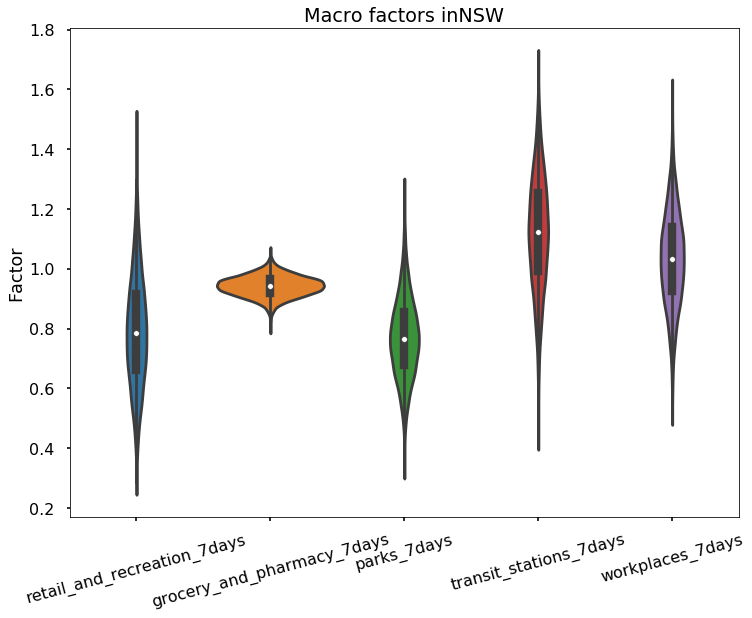

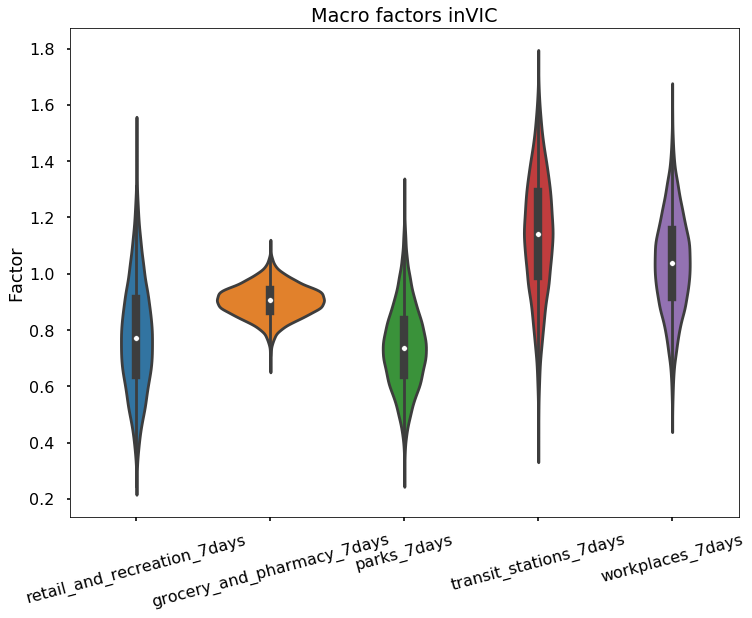

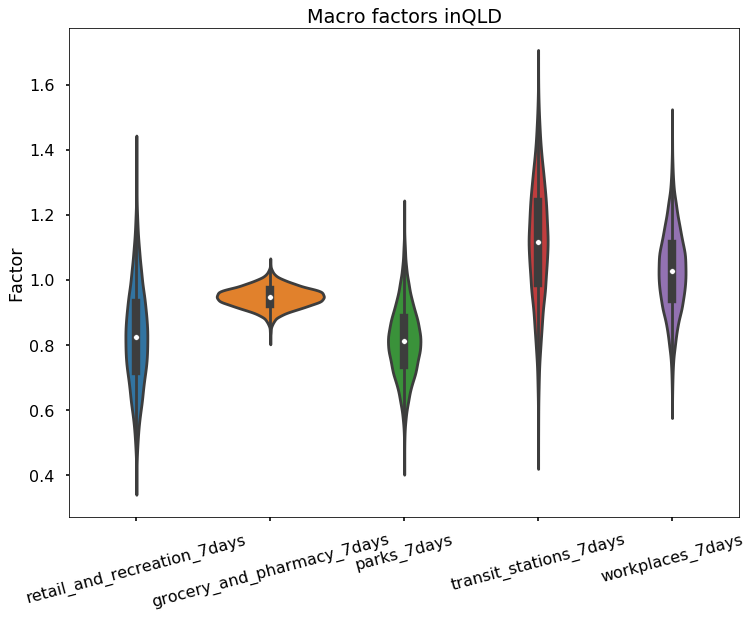

In [18]:
### Impact of individual parts
#Take last Google index, 21st May
for state in ['NSW','VIC','QLD']:
    single_pred = {}

    for i,pred in enumerate(predictors):
        X = df_R.loc[(df_R.date=='2020-03-29')&(df_R.state==state),pred].values/100 #predictors


        post_values = samples[pred].values.T #K by 1000


        last_RL_nomd = 2*expit(X * post_values) # 1 by K times K 1000
        single_pred[pred]= last_RL_nomd.flatten()

    plot_df = pd.melt(pd.DataFrame.from_dict(single_pred))
    print(state)
    print(pd.DataFrame.from_dict(single_pred).median())
    fig,ax = plt.subplots(figsize=(12,9))
    sns.violinplot(
            x='variable',
            y='value',
            data = plot_df,
            ax=ax,
        cut=1,
    )

    ax.set_title("Macro factors in" +state)
    ax.set_yticks([1],minor=True,)
    #ax.set_yticks([0,2,3],minor=False)
    ax.set_ylabel('Factor')
    ax.set_xlabel('')
    ax.tick_params('x', rotation=15)
    ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
plt.show()

In [308]:
df_R.loc[df_R.date=='2020-03-23']

,date,state,retail_and_recreation_7days,grocery_and_pharmacy_7days,parks_7days,transit_stations_7days,workplaces_7days,policy
755,2020-05-23,AUS,-24.571429,-0.285714,-24.571429,-45.857143,-20.428571,1
754,2020-05-23,TAS,-30.857143,-13.142857,-55.142857,-48.714286,-15.000000,1
753,2020-05-23,ACT,-26.285714,-1.428571,7.285714,-43.142857,-23.000000,1
752,2020-05-23,SA,-19.285714,4.714286,-20.571429,-35.428571,-12.142857,1
751,2020-05-23,VIC,-31.000000,-2.857143,-24.714286,-56.142857,-28.142857,1
750,2020-05-23,QLD,-19.000000,2.000000,-10.428571,-44.714286,-15.000000,1
749,2020-05-23,NSW,-25.857143,-0.571429,-29.285714,-44.714286,-22.142857,1
748,2020-05-23,WA,-19.857143,1.428571,-38.714286,-45.285714,-12.285714,1
747,2020-05-23,NT,-3.000000,20.571429,11.571429,-27.714286,6.000000,1


In [40]:
min_RL = 2*df_samples.md.values*expit(X @ post_values) # 1 by K times K 1000
2*df_samples.md.values*expit(X @ post_values)

array([[0.40029017, 0.55652395, 0.44423486, ..., 0.32070831, 0.31617324,
        0.30867425]])

In [42]:
min_RL = 2*df_samples.md.values*expit(X @ post_values)

In [44]:
min_RL.shape

(1, 10000)